In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from string import ascii_uppercase
import re

from astropy.table import Table, join, Column,vstack, hstack

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


In [2]:
fname = '../data/haloC4.csv'
data = Table.read(fname,format='ascii')
shortcad = open('../data/shortcad.txt','r').read().split('\n')

In [3]:
data

Name,Vmag,Sp. Type,EPIC ID,RA (J2000),Dec (J2000),MASK,Comments
str8,float64,str12,int64,str24,int64,str7,str17
Alcyone,2.986,B7III,200007767,--,--,LC Halo,\tablenotemark{a}
Atlas,3.763,B8III,200007768,--,--,LC Halo,\tablenotemark{a}
Electra,3.851,B6IIIe,200007769,--,--,LC Halo,\tablenotemark{a}
Merope,4.305,--,200007770,B6IVe,--,LC Halo,\tablenotemark{a}
Maia,4.305,--,200007771,B8III,--,LC Halo,\tablenotemark{a}
Taygeta,4.448,--,200007772,B6IV,--,LC Halo,\tablenotemark{a}
Pleione,5.192,--,200007773,B8Vne,--,LC Halo,\tablenotemark{a}
gam Tau,3.474,--,200007765,G9.5III\tablenotemark{1},--,LC Halo,--
del1 Tau,3.585,G9.5IIICN0.5,200007766,--,--,LC Halo,--


In [4]:
campaigns = range(4,19)
objective = 'tv'
lag = 10
template = "wget -q -nH --cut-dirs=6 -r -l0 -c -N -np -R 'index*' -erobots=off"

f = open('../data/download_halo.txt','w')
h = open('../scripts/sbatch_k2sc_all.txt','w')
h.write('python correct_halo.py -c 6 -name Spica --objective %s &> Spica_output.txt\n' % objective) # do Spica manually
k = open('../reduced/sbatch_halo_all.txt','w')
short = open('../reduced/short.txt','w')
for campaign in campaigns:
    if campaign == 5:
        continue
    print('Campaign',campaign,'\n')
    g = open('../reduced/halo_commands_c%d.txt' % campaign,'w')
    fname = '../data/haloC%d.csv' % campaign
    print(fname)
    data = Table.read(fname,format='ascii')
    
    for star in data:
        epic = star['EPIC ID']
        if 'alo' in star['MASK']:
            print(star['Name'],star['EPIC ID'],star['MASK'])
            if campaign == 11:
                campaign = 111 # no 112
            fname = 'ktwo%d-c%02d_lpd-targ.fits.gz' % (epic,campaign)
            shortfname = fname.replace('lpd','spd')
            if campaign in [9, 10]:
                for j in [1,2]:
                    fname = 'ktwo%d-c%d%d_lpd-targ.fits.gz' % (epic,campaign,j)
                    url = 'https://archive.stsci.edu/pub/k2/target_pixel_files/c%d%d/%s00000/%s000/%s' % (campaign,j,str(epic)[:4],str(epic)[4:6],fname)
                    command = template+' '+url
                    f.write(command+'\n')
                    halocommand = 'halo %s --data-dir ../data/ --save-dir ../reduced/c%d%d/ --name %s -c %d%d --thresh 0.5 --objective %s --lag %d --do-plot\n' % (fname,campaign,j,star['Name'].replace(' ','_'),campaign,j,objective,lag)
                    if campaign ==9:
                        halocommand = 'halo %s --data-dir ../data/ --save-dir ../reduced/c%d%d/ --name %s -c %d%d --thresh 0.5 --objective %s --lag %d --deathstar --do-plot\n' % (fname,campaign,j,star['Name'].replace(' ','_'),campaign,j,objective,lag)
                    g.write(halocommand)
                    k.write(halocommand)
                    if shortfname in shortcad:
                        shortcommand = 'halo %s --data-dir ../data/ --save-dir ../reduced/short/ --name %s -c %d%d --thresh 0.5 --objective %s --lag 300 --deathstar --do-plot\n' % (shortfname,star['Name'].replace(' ','_'),campaign,j,objective)
                        short.write(shortcommand)

                    if (campaign == 10) and (j == 2):
                        k2sc_command = 'python correct_halo.py -c %d%d -name %s --objective %s &> %s_output%d.txt' % (campaign,j,star['Name'].replace(' ','_'),objective,star['Name'].replace(' ','_'),j)
                        h.write(k2sc_command+'\n')
            else:
                url = 'https://archive.stsci.edu/pub/k2/target_pixel_files/c%d/%s00000/%s000/%s' % (campaign,str(epic)[:4],str(epic)[4:6],fname)
                command = template+' '+url
                f.write(command+'\n')
                k2sc_command = 'python correct_halo.py -c %d -name %s --objective %s &> %s_output.txt' % (campaign,star['Name'].replace(' ','_'),objective,star['Name'].replace(' ','_'))
                h.write(k2sc_command+'\n')

#             print(command)
                halocommand = 'halo %s --data-dir ../data/ --save-dir ../reduced/c%d/ --name %s -c %d --thresh 0.5 --objective %s --lag %d --do-plot\n' % (fname,campaign,star['Name'].replace(' ','_'),campaign,objective,lag)
                g.write(halocommand)
                k.write(halocommand)
                if shortfname in shortcad:
                    shortcommand = 'halo %s --data-dir ../data/ --save-dir ../reduced/short/ --name %s -c %d --thresh 0.5 --objective %s --lag 300 --do-plot\n' % (shortfname,star['Name'].replace(' ','_'),campaign,objective)
                    short.write(shortcommand)

#             print(halocommand)
    g.close()
    print('\n')
f.close()
h.close()
k.close()
short.close()

Campaign 4 

../data/haloC4.csv
Alcyone 200007767 LC Halo
Atlas 200007768 LC Halo
Electra 200007769 LC Halo
Merope 200007770 LC Halo
Maia 200007771 LC Halo
Taygeta 200007772 LC Halo
Pleione 200007773 LC Halo
gam Tau 200007765 LC Halo
del1 Tau 200007766 LC Halo


Campaign 6 

../data/haloC6.csv


Campaign 7 

../data/haloC7.csv
Ascella 200062593 Halo
Albaldah 200062592 Halo
tau Sgr 200062591 Halo
ksi2 Sgr 200062590 Halo
omi Sgr 200062589 Halo
52 Sgr 200062585 Halo
Ainalrami 200062588 Halo
psi Sgr 200062584 Halo
43 Sgr 200062587 Halo
nu2 Sgr 200062586 Halo


Campaign 8 

../data/haloC8.csv
eps Psc 200068392 Halo
Revati 200068393 Halo
80 Psc 200068394 Halo
42 Cet 200068399 Halo
33 Cet 200068395 Halo
60 Psc 200068396 Halo
73 Psc 200068397 Halo
WW Psc 200068398 Halo
HR 243 200068400 Halo
HR 161 200068401 Halo


Campaign 9 

../data/haloC9.csv
HR 6766 200069361 Halo
HR 6842 200069360 Halo
4 Sgr 200069357 Halo
11 Sgr 200069358 Halo
7 Sgr 200069362 Halo
15 Sgr 200069359 Halo
HR 6838 200069363 

In [5]:
fname.replace('lpd','lpd')

'ktwo200233194-c18_lpd-targ.fits.gz'

### Now let us make some tables for the paper


In [6]:
data[['Halo' in mask for mask in data['MASK']]]

Name,Vmag,Sp. Type,EPIC ID,RA (J2000) [deg],Dec (J2000) [deg],MASK,Investigation IDs,TPF,LC Halo Lightcurve,Lightcurve Image,Weight Image,Flux Image,Project,Contact,Publication,Comments
str8,float64,str12,int64,float64,float64,str7,str87,int64,int64,int64,int64,int64,int64,int64,int64,str7
gam Cnc,4.652,A1IV,200233186,130.8214508,21.46850022,Halo,GO18038|GO18051|GAMMA_CANCRI-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,C5
zet Cnc,4.67,F8V+G0V,200233643,123.0530265,17.64776708,Halo,GO18038|GO18051|ZETA_CANCRI-SC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,C5
eta Cnc,5.325,K3III,200233187,128.1770667,20.44116292,Halo,GO18038|GO18051|ETA_CANCRI-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,"C5, C16"
60 Cnc,5.44,K5III,200233188,133.98145,11.62602,Halo,GO18051|GO18068|60_CANCRI-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,"C5, C16"
49 Cnc,5.66,A1VpHgMnSiEu,200233189,131.1876504,10.08166753,Halo,GO18049|GO18051|GO18067|49_CANCRI-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,C5
HR 3264,5.798,K1III,200233190,125.08739,20.74772,Halo,GO18051|GO18068|HR_3264-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,C5
50 Cnc,5.885,A1Vp,200233191,131.7334112,12.10995057,Halo,GO18038|GO18049|GO18051|50_CANCRI-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,"C5, C16"
29 Cnc,5.948,A5V,200233192,127.1555775,14.21082345,Halo,GO18049|GO18051|29_CANCRI-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,C5
HR 3222,6.047,G8III,200233193,123.2488715,16.51431877,Halo,GO18051|HR_3222-LC-BRIGHT_STAR_DISC,--,--,--,--,--,--,--,--,C5


In [7]:
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy import units as u



In [8]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('sptype')
sim = Simbad.query_objects(data['Name'])
data['SpType'] = sim['SP_TYPE']


In [9]:
from astropy.io import ascii
names = ['Name','EPIC','RA (J2000)','Dec (J2000)','Spectral','V']
units = ['', '', '(deg)','(deg)','Type','mag']

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))


In [10]:
# dwarf_variability = Table.read('../data/dwarf_variability.csv',format='ascii')
variability = Table.read('../data/dwarf_variability_new.csv',format='csv',encoding='utf-8-sig')['Campaign','Name','Classification','Notes']
variability_2 = Table.read('../data/unclassifieds.csv',format='csv',encoding='utf-8-sig')['Campaign','Name','Classification','Notes']

dwarf_variability = vstack([variability,variability_2])
dwarf_variability.sort('Campaign')
print(len(dwarf_variability))

92


In [11]:
rgs = Table.read('../data/TargetsSeisParamsShort.csv',format='ascii')

In [12]:
rgs

epicid,numax,numaxerr,dnu,dnuerr
int64,float64,float64,float64,float64
200007765,62.88519,1.43641,5.56429,0.17444
200007766,62.59123,1.74219,5.71903,0.06925
200062586,7.29299,0.14925,1.31019,0.04631
200062590,11.7125,0.64569,1.87258,0.14649
200062591,19.8491,0.80192,2.4554,0.06599
200062592,46.95148,0.43368,5.96658,0.20496
200068392,33.30912,1.21748,3.62276,0.0688
200164170,10.13819,0.39047,1.56261,0.05254
200164173,11.37651,0.22821,1.69055,0.0571


In [13]:
to_write = data[['Halo' in mask for mask in data['MASK']]]['Name','EPIC ID','RA (J2000) [deg]','Dec (J2000) [deg]','SpType','Vmag']
to_write.rename_column('EPIC ID','EPIC')
to_write.rename_column('RA (J2000) [deg]','RA (J2000)')
to_write.rename_column('Dec (J2000) [deg]','Dec (J2000)')
to_write.rename_column('SpType','Spectral')
to_write.rename_column('Vmag','V')
to_write['Campaign'] = campaign*np.ones(len(to_write),dtype='int')


caption = r"All stars observed with halo photometry in Campaign %d." % campaign 
to_write.write('../paper/table_c%d.tex' % campaign,format='latex',latexdict=latexdict,caption=caption+'\label{table_c%d}' % campaign,overwrite=True)
print('Written %s' % '../paper/table_c%d.tex' % campaign)


Written ../paper/table_c18.tex


In [14]:
simgreek = ['alf','bet','gam','del','eps','zet','eta','tet','iot','kap','lam','mu','nu','ksi','omi','pi','rho','sig','tau','ups','phi','khi','psi','ome']
latexgreek = ['\\alpha', '\\beta', '\\gamma','\\delta','\\epsilon','\\zeta','\\eta','\\theta','\\iota','\\kappa','\\lambda','\\mu','\\nu','\\xi','o','\\pi','\\rho','\\sigma','\\tau','\\upsilon','\\phi','\\chi','\\psi','\\omega']
def translate_greek(word):
    for j, letter in enumerate(simgreek):
        if letter in word:
            word = word.replace(letter,'$%s$' % latexgreek[j])
            return(word)
    return(word)



In [15]:
def raise_indices(line):
    try:
        match = re.search('\$(\d+)',line).group()
        return (line.replace(match,r'^{%s}$' % match[1:]))
    except:
        return(line)

In [16]:
raise_indices(r'$\delta$1 Sct')

'$\\delta^{1}$ Sct'

In [17]:
proper_names = Table.read('proper_names.csv',format='csv')

In [18]:
proper_names

Proper,Paper
str17,str9
Alcyone,eta Tau
Atlas,27 Tau
Electra,17 Tau
Maia,20 Tau
Merope,23 Tau
Taygeta,19 Tau
Pleione,28 Tau
Ascella,zet Sgr
Albaldah,pi Sgr


In [19]:
translator_class = {'RG':'RG',
                    'Cepheid':'Cepheid',
                    'GD':r'$\gamma\,\text{Dor}$',
                    'DS':r'$\delta\,\text{Sct}$',
                    '?':'?',
                    '-':r'--',
                    'BC':r'$\beta$\,Cep',
                    'a2CVn':r'$\alpha^2\,\text{CVn}$',
                    'Quiet':r'--',
                    'f':r'$^f$'
                   }


In [20]:
def truncate_sptype(line_in):
    lum_classes = ['IV','V','III','II','I']

    peculiar = ''

    for thing in ['p','m','e','?']:
        if thing in line_in:
            peculiar += thing
            line_in = line_in.strip(thing)

    lines = (line_in.split('+'))
    out = []
    

    for line in lines:
        for lum in lum_classes:
            ind = line.find(lum)
            if ind>0:
                out.append(line[:(ind+len(lum))])
                break
        
    if out == []:
        return(line_in+peculiar)
    else:
        return ('+'.join(out)+peculiar)

In [21]:
campaigns = range(4,19)

campaign_tables = []

missing = []
weird = {'44 Oph':'A3m',
         'Acubens':'A5m',
         'HR 6366':'Fm',
         'Porrima':'F1V+F2Vm',
         '35 Sex':'K1+K2III',
         'HD 165052':'O6V+O8V',
         'HD 138810':'K1III'}


for campaign in campaigns:
    if campaign == 5:
        continue
    print('Campaign',campaign,'\n')
    
    fname = '../data/haloC%d.csv' % campaign
    data = Table.read(fname,format='ascii')
    data=data[~data['Name'].mask]
    
    sc = data[['SC' in mask for mask in data['MASK']]]
    data = data[['SC' not in mask for mask in data['MASK']]]
    
    sim = Simbad.query_objects(data['Name'])
    if campaign == 4:
        sim = sim[sim['COO_ERR_MAJA']<10]
    
    data['SpType'] = Column([truncate_sptype(sptype.replace('_',' ')) for sptype in sim['SP_TYPE'].astype('str')],name='SpType')
    for key in weird:
        ind = (data['Name'] == key)
        if sum(ind)>0:
            print('Weird star',key)
        data['SpType'][ind] = weird[key]
    data['Campaign'] = campaign*np.ones(len(data),dtype='int')
    
    if campaign != 6:
        to_write = data[['Halo' in mask for mask in data['MASK']]]['Name','EPIC ID','SpType','Vmag','Campaign','Comments']
    else:
        to_write = data['Name','EPIC ID','SpType','Vmag','Campaign','Comments']
    to_write['Comments']= to_write['Comments'].astype('str')
    for short in sc['Name']:
        to_write['Comments'][to_write['Name']==short] = 'SC' 
    to_write.rename_column('EPIC ID','EPIC')
    to_write.rename_column('Comments','Notes')
#     to_write.rename_column('RA (J2000) [deg]','RA (J2000)')
#     to_write.rename_column('Dec (J2000) [deg]','Dec (J2000)')
    to_write.rename_column('SpType','Spectral')
    to_write.rename_column('Vmag','V')
    variability = []
    for star in to_write:
        name = star['Name']#.replace(' ','_')
        epic = star['EPIC']
        if name in dwarf_variability['Name']:
            index = np.where(dwarf_variability['Name']==name)[0]
            var = dwarf_variability['Classification'][index].data.data[0]
            for key in translator_class.keys():
                var = var.replace(key,translator_class[key])
#             print('%s is a %s variable' % (name,str(var)))
            variability.append(var)
        elif epic in rgs['epicid']:
            var = 'RG'
#             print('%s is a %s variable' % (name,var))
            variability.append(var)
        else:
#             print('%s is not variable' % (name))
            missing.append(name.replace('_',' '))
            variability.append('--')
    to_write.add_column(Column(variability,name='Class'))
    campaign_tables.append(to_write)
    
all_write = vstack(campaign_tables)
all_write['Campaign'] = all_write['Campaign'].astype('str')

repeated = set([i for i in all_write['Name'] if sum([1 for a in all_write['Name'] if a == i]) > 1])
for repeat in repeated:
    print(repeat,'repeated')
    m = (all_write['Name']==repeat)
    all_write[np.where(m)[0][0]]['Campaign'] += ', %s' % all_write[m]['Campaign'][1]
    all_write.remove_row(np.where(m)[0][1])
    
names = []
propernames = []
new_names = []
for j, name in enumerate(all_write['Name']):
    try:
        if name=='36 Oph':
            new_names.append('36 Oph')
            names.append(name)
            propernames.append('Guniibuu')
        else:
            index = np.where(proper_names['Proper']==name)[0]
            new_name = raise_indices(translate_greek(proper_names['Paper'][index].data[0]))
            print(name,new_name)
            new_names.append(new_name)
            propernames.append(name)
            names.append(new_name)
    except:
        names.append(raise_indices(translate_greek(name)))
        
all_write.replace_column('Name',Column([raise_indices(name) for name in names],name='Name'))

units = ['','','Type','(mag)','','']
latexdict_apj = {'units':dict(zip(all_write.keys(),units))}
caption = r"All stars observed with halo photometry in K2."
all_write.write('../paper/table_all.tex',format='aastex',caption=caption+'\label{table_all}',
                latexdict=latexdict_apj,overwrite=True)
print('Written %s' % '../paper/table_all.tex')
tablenotes = [' \\tablenotetext{a}{\citet{White2017}}',
              ' \\tablenotetext{b}{\citet{Buysschaert2018}}',
              ' \\tablenotetext{c}{\citet{Farr2018}}',
              ' \\tablenotetext{d}{\citet{Arentoft2019}}',
              ' \\tablenotetext{e}{\citet{Aerts2018}}']

tablenotes_core = {'a': '\citet{White2017}',
              'b': '\citet{Buysschaert2018}',
              'c':'\citet{Farr2018}',
              'd': '\citet{Arentoft2019}',
              'e':'\citet{Aerts2018}',
             'f':r'Light curve shows RG pulsations, but is also significantly contaminated by the higher amplitude $\delta$~Sct pulsations of the nearby $\theta^2$~Tau.'}
tablenotes = ['\\tablerefs{' + '; '.join(['$^%s$:~%s' % (key, tablenotes_core[key]) for key in tablenotes_core.keys()])+ '}']

table_explanation = 'Some targets are known by proper names. ' + "; ".join([part[1]+': '+part[0] 
                                                                            for part in (list(zip(proper_names['Proper'],
                                                                                                  [raise_indices(translate_greek(name)).replace(' ','~') for name in proper_names['Paper']])))])

tablenotes = tablenotes + ['\\tablecomments{%s}' %  table_explanation]
with open('../paper/table_all.tex', 'r') as original: oldtext = original.read().replace('\end{deluxetable}',
                                                                                        '\n'.join(tablenotes)+
                                                                                        '\n\end{deluxetable}').replace('{ccccccc}','{ccllccl}')
with open('../paper/table_all.tex', 'w') as modified: modified.write("\\startlongtable\n" + oldtext)


Campaign 4 

Campaign 6 

Campaign 7 

Campaign 8 

Campaign 9 

Weird star HD 165052
Campaign 10 

Weird star Porrima
Campaign 11 



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: StringTruncateWarning: truncated right side string(s) longer than 7 character(s) during assignment
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: StringTruncateWarning: truncated right side string(s) longer than 7 character(s) during assignment
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: StringTruncateWarning: truncated right side string(s) longer than 5 character(s) during assignment
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: StringTruncateWarning: truncated right side string(s) longer than 5 character(s) during assignment
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: StringTruncateWarning: truncated right side string(s) longer than 5 character(s) during assignment


Weird star 44 Oph
Weird star HR 6366
Campaign 12 

Campaign 13 

Campaign 14 

Weird star 35 Sex
Campaign 15 

Weird star HD 138810
Campaign 16 

Weird star Acubens
Campaign 17 



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: StringTruncateWarning: truncated right side string(s) longer than 7 character(s) during assignment
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: StringTruncateWarning: truncated right side string(s) longer than 7 character(s) during assignment


Campaign 18 

50 Cnc repeated
eta Cnc repeated
Spica repeated
Alcyone $\eta$ Tau
Atlas 27 Tau
Electra 17 Tau
Merope 23 Tau
Maia 20 Tau
Taygeta 19 Tau
Pleione 28 Tau
Spica $\alpha$ Vir
Ascella $\zeta$ Sgr
Albaldah $\pi$ Sgr
Ainalrami $\nu^{1}$ Sgr
Revati $\zeta$ Psc A
Porrima $\gamma$ Vir
Zaniah $\eta$ Vir
Aldebaran $\alpha$ Tau
Dschubba $\delta$ Sco
Zubenelhakrabi $\gamma$ Lib
Asellus Australis $\delta$ Cnc
Acubens $\alpha$ Cnc
Written ../paper/table_all.tex


In [22]:
table_explanation

'Some targets are known by proper names. $\\eta$~Tau: Alcyone; 27~Tau: Atlas; 17~Tau: Electra; 20~Tau: Maia; 23~Tau: Merope; 19~Tau: Taygeta; 28~Tau: Pleione; $\\zeta$~Sgr: Ascella; $\\pi$~Sgr: Albaldah; $\\nu^{1}$~Sgr: Ainalrami; $\\zeta$~Psc~A: Revati; $\\gamma$~Vir: Porrima; $\\eta$~Vir: Zaniah; $\\alpha$~Tau: Aldebaran; $\\delta$~Sco: Dschubba; $\\gamma$~Lib: Zubenelhakrabi; $\\delta$~Cnc: Asellus Australis; $\\alpha$~Cnc: Acubens; $\\alpha$~Vir: Spica; 36~Oph: Guniibuu; $\\gamma$~Tau: Prima Hyadum; $\\delta^{1}$~Tau: Secunda Hyadum; $\\theta^{2}$~Tau: Chamukuy; $\\epsilon$~Tau: Ain; $\\xi$~Cnc: Nahn; $\\gamma$~Cnc: Asellus Borealis; $\\zeta$~Cnc: Tegmine'

In [23]:
print(len(np.unique(all_write['Name'])),'unique stars')

161 unique stars


In [24]:
classes = ['?','BC','Cepheid','DS','GD','DS/GD','EB','SPB','Quiet','O','RG','Rotation','Supergiant','a2CVn']

In [25]:
for cl in classes:
    ncl = sum([cl in var for var in dwarf_variability['Classification']])
    print(ncl,cl,'in our sample')

3 ? in our sample
4 BC in our sample
3 Cepheid in our sample
23 DS in our sample
20 GD in our sample
9 DS/GD in our sample
2 EB in our sample
14 SPB in our sample
17 Quiet in our sample
3 O in our sample
3 RG in our sample
8 Rotation in our sample
5 Supergiant in our sample
2 a2CVn in our sample


In [26]:
dwarf_variability[['?' in var for var in dwarf_variability['Classification']]]

Campaign,Name,Classification,Notes
int64,str9,str14,int64
8,42 Cet,?,--
11,omi Oph,?,--
13,HR 1427,GD?,--


In [27]:
truncate_sptype('kA5hA9mF1III')

'kA5hA9mF1IIIm'

In [28]:
for sptype in data['SpType']:
    print('Input:',sptype,'Output:',truncate_sptype(sptype))

Input: A1IV Output: A1IV
Input: F8V+G0V Output: F8V+G0V
Input: K3III Output: K3III
Input: K5III Output: K5III
Input: K5III Output: K5III
Input: A1Vp Output: A1Vp
Input: K1III Output: K1III
Input: K1III Output: K1III
Input: A1Vp Output: A1Vp
Input: A5V Output: A5V
Input: G8III Output: G8III
Input: G8III Output: G8III
Input: M2III Output: M2III
Input: M2III Output: M2III
Input: F5IIIm? Output: F5IIIm?
Input: F5IIIm? Output: F5IIIm?
Input: K1III Output: K1III
Input: G8+III-IIIb Output: G8+III-IIIb
Input: C-N4.5 Output: C-N4.5
Input: C-N4.5 Output: C-N4.5
Input: K0 Output: K0
Input: F8 Output: F8
Input: G8III Output: G8III
Input: G5 Output: G5
Input: K0 Output: K0
Input: G8III Output: G8III
Input: G5 Output: G5
Input: K0 Output: K0
Input: K2 Output: K2
Input: G5 Output: G5
Input: K0 Output: K0
Input: G5 Output: G5
Input: G5 Output: G5
Input: G5 Output: G5
Input: K0 Output: K0
Input: G5 Output: G5
Input: K0 Output: K0


In [29]:
[raise_indices(name) for name in names]

['$\\eta$ Tau',
 '27 Tau',
 '17 Tau',
 '23 Tau',
 '20 Tau',
 '19 Tau',
 '28 Tau',
 '$\\gamma$ Tau',
 '$\\delta^{1}$ Tau',
 '$\\alpha$ Vir',
 '69 Vir',
 '$\\zeta$ Sgr',
 '$\\pi$ Sgr',
 '$\\tau$ Sgr',
 '$\\xi^{2}$ Sgr',
 '$o$ Sgr',
 '52 Sgr',
 '$\\nu^{1}$ Sgr',
 '$\\psi$ Sgr',
 '43 Sgr',
 '$\\nu^{2}$ Sgr',
 '$\\epsilon$ Psc',
 '$\\zeta$ Psc A',
 '80 Psc',
 '42 Cet',
 '33 Cet',
 '60 Psc',
 '73 Psc',
 'WW Psc',
 'HR 243',
 'HR 161',
 'HR 6766',
 'HR 6842',
 '4 Sgr',
 '11 Sgr',
 '7 Sgr',
 '15 Sgr',
 'HR 6838',
 'Y Sgr',
 'HR 6716',
 'HR 6681',
 '9 Sgr',
 '16 Sgr',
 'HR 6825',
 '63 Oph',
 'HR 6679',
 'HD 165784',
 'HD 161083',
 '5 Sgr',
 'HD 167576',
 'HR 6773',
 'HD 163296',
 'HD 165052',
 '17 Sgr',
 'HD 169966',
 'HD 162030',
 '$\\gamma$ Vir',
 '$\\eta$ Vir',
 '21 Vir',
 'FW Vir',
 'HR 4837',
 'HR 4591',
 'HR 4613',
 'HD 107794',
 '$\\theta$ Oph',
 '44 Oph',
 '45 Oph',
 '51 Oph',
 '36 Oph',
 '$o$ Oph',
 '26 Oph',
 'HR 6472',
 'HR 6366',
 'HR 6365',
 '191 Oph',
 '$\\kappa$ Psc',
 '83 Aqr',


In [30]:
tablenotes_core = {'a': '\citet{White2017}',
              'b': '\citet{Buysschaert2018}',
              'c':'\citet{Farr2018}',
              'd': '\citet{Arentoft2019}',
              'e':'\citet{Aerts2018}',
             '*':'Light curve shows RG pulsations, but is also significantly contaminated by the higher amplitude $\delta$~Sct pulsations of the nearby $\theta^2$~Tau'}
# tablenotes = ['\\tablerefs{$^a$: \citet{White2017}; $^b$: \citet{Buysschaert2018}; $^c$: \citet{Farr2018}; $^d$: \citet{Arentoft2019}; $^e$:\citet{Aerts2018}']
tablenotes = ['\\tablerefs{' + '; '.join(['$^%s$: %s' % (key, tablenotes_core[key]) for key in tablenotes_core.keys()])+ '}']
print(tablenotes)


['\\tablerefs{$^a$: \\citet{White2017}; $^b$: \\citet{Buysschaert2018}; $^c$: \\citet{Farr2018}; $^d$: \\citet{Arentoft2019}; $^e$: \\citet{Aerts2018}; $^*$: Light curve shows RG pulsations, but is also significantly contaminated by the higher amplitude $\\delta$~Sct pulsations of the nearby $\theta^2$~Tau}']


In [31]:
table_explanation

'Some targets are known by proper names. $\\eta$~Tau: Alcyone; 27~Tau: Atlas; 17~Tau: Electra; 20~Tau: Maia; 23~Tau: Merope; 19~Tau: Taygeta; 28~Tau: Pleione; $\\zeta$~Sgr: Ascella; $\\pi$~Sgr: Albaldah; $\\nu^{1}$~Sgr: Ainalrami; $\\zeta$~Psc~A: Revati; $\\gamma$~Vir: Porrima; $\\eta$~Vir: Zaniah; $\\alpha$~Tau: Aldebaran; $\\delta$~Sco: Dschubba; $\\gamma$~Lib: Zubenelhakrabi; $\\delta$~Cnc: Asellus Australis; $\\alpha$~Cnc: Acubens; $\\alpha$~Vir: Spica; 36~Oph: Guniibuu; $\\gamma$~Tau: Prima Hyadum; $\\delta^{1}$~Tau: Secunda Hyadum; $\\theta^{2}$~Tau: Chamukuy; $\\epsilon$~Tau: Ain; $\\xi$~Cnc: Nahn; $\\gamma$~Cnc: Asellus Borealis; $\\zeta$~Cnc: Tegmine'

In [32]:
missing_class = join(Table([Column(missing,name='Name')]),vstack(campaign_tables),keys='Name')['Name','Spectral','Campaign']
missing_class.write('missing_class.csv')

In [33]:
tablenotes = ['\tablenotetext{a}{\citet{White2017}}']*5
'\n'.join(tablenotes)

'\tablenotetext{a}{\\citet{White2017}}\n\tablenotetext{a}{\\citet{White2017}}\n\tablenotetext{a}{\\citet{White2017}}\n\tablenotetext{a}{\\citet{White2017}}\n\tablenotetext{a}{\\citet{White2017}}'

In [34]:
for l, ccat in enumerate([all_write[:29],all_write[29:54],all_write[54:81],all_write[81:114],all_write[114:134],all_write[134:]]):
    latexdict = ascii.latex.latexdicts['AA'].copy()
    latexdict['tabletype']= 'table*'
    latexdict['units'] = dict(zip(names,units))
    
    campaigns_list = ['Campaigns 7-8','Campaign 9','Campaigns 10-12','Campaign 13','Campaigns 14-15','Campaigns 16-18']

    caption = "Stars in %s observed with halo photometry in K2." % campaigns_list[l]
    ccat.write('../paper/all_stars_%d.tex' % (l+1),format='latex',latexdict=latexdict,caption=caption+'\label{table_%s}' % l,overwrite=True)
    print('Written %s' % '../paper/all_stars_%d.tex' % (l+1))
        


Written ../paper/all_stars_1.tex
Written ../paper/all_stars_2.tex
Written ../paper/all_stars_3.tex
Written ../paper/all_stars_4.tex
Written ../paper/all_stars_5.tex
Written ../paper/all_stars_6.tex


### Which are giants and which are main sequence?


In [35]:
Simbad.reset_votable_fields()
# Simbad.list_votable_fields()
Simbad.add_votable_fields('parallax')
sim = Simbad.query_objects(data['Name'])
# data['SpType'] = sim['SP_TYPE']


In [36]:
def abs_mag(app_mag,dist):
    return app_mag - 5.*(np.log10(dist) - 1.)

In [37]:
abs_V = abs_mag(data['Vmag'],1./(sim['PLX_VALUE']))

In [38]:
campaigns = range(6,19)

campaign_tables = []

Simbad.add_votable_fields('parallax')
Simbad.add_votable_fields('parallax')
Simbad.add_votable_fields('flux(B)')
Simbad.add_votable_fields('sptype')


for campaign in campaigns:
    print('Campaign',campaign,'\n')
    
    fname = '../data/haloC%d.csv' % campaign
    data = Table.read(fname,format='ascii')
    data=data[~data['Name'].mask]

    data = data[['SC' not in mask for mask in data['MASK']]]
    sim = Simbad.query_objects(data['Name'])
    data['SpType'] = Column([sptype.replace('_',' ') for sptype in sim['SP_TYPE'].astype('str')],name='SpType')

    data['parallax'] = Column([parallax for parallax in sim['PLX_VALUE']],name='parallax')
    data['Bmag'] = Column([b for b in sim['FLUX_B']],name='Bmag')

    data['Campaign'] = campaign*np.ones(len(data),dtype='int')
            
    to_write = data[['Halo' in mask for mask in data['MASK']]]['Name','EPIC ID','Vmag','Bmag','Campaign','parallax','SpType']
    to_write.rename_column('EPIC ID','EPIC')
    campaign_tables.append(to_write)
    
all_plot = vstack(campaign_tables)
all_plot['parallax'][all_plot['Name']=='omi Oph'] = 11.5763
all_plot['Campaign'] = all_plot['Campaign'].astype('str')
all_plot['abs_Vmag'] = abs_mag(all_plot['Vmag'],1./(all_plot['parallax']/1000.))
all_plot['b_v'] = all_plot['Bmag']-all_plot['Vmag']


all_plot['b_v'][all_plot['Name']=='36 Oph'] = 0.85 # multiple systems
all_plot['b_v'][all_plot['Name']=='omi Oph'] = 1.1




Campaign 6 

Campaign 7 

Campaign 8 

Campaign 9 

Campaign 10 

Campaign 11 

Campaign 12 

Campaign 13 



/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:221: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)
/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:221: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)


Campaign 14 

Campaign 15 

Campaign 16 

Campaign 17 

Campaign 18 



/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:221: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)


In [39]:
giants = np.array(['III' in sptype for sptype in all_plot['SpType']])

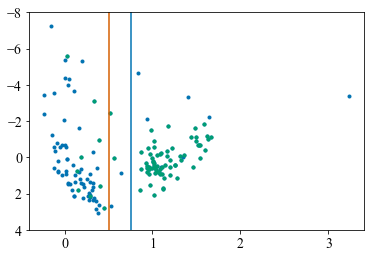

In [40]:
plt.plot(all_plot['b_v'],all_plot['abs_Vmag'],'.')
plt.plot(all_plot['b_v'][giants],all_plot['abs_Vmag'][giants],'.')

plt.ylim(4,-8)
plt.axvline(0.75)
plt.axvline(0.5,color=colours[2])

In [41]:
funny = (all_plot['b_v']<0.75)*(all_plot['b_v']>0.5)
all_plot[funny]

Name,EPIC,Vmag,Bmag,Campaign,parallax,SpType,abs_Vmag,b_v
str17,int64,float64,float64,str21,float64,str21,float64,float64
psi Sgr,200062584,4.85,5.409999847412109,7,10.93,K0/1III+A/F,0.04310080974851438,0.5599998474121097
42 Cet,200068399,5.87,6.510000228881836,8,9.93,G8IV+A(8),0.8547462424769057,0.6400002288818358
7 Sgr,200069362,5.34,5.860000133514404,9,2.8053,F2II-III,-2.4201034414191778,0.5200001335144044
zet Cnc,200233643,4.67,5.199999809265137,18,39.87,F8V+G0V,2.6732311783119727,0.5299998092651368


In [42]:
# psi Sgr is a giant
# 42 Cet is a subgiant
# 7 Sgr is a giant

In [43]:
Table(all_plot['Name','EPIC'][all_plot['b_v']>0.5]).write('halo_giants.csv')
Table(all_plot['Name','EPIC'][all_plot['b_v']<0.5]).write('halo_dwarfs.csv')


In [44]:
# tab.write('halo_giants.csv')

In [45]:
-np.floor(np.log10(1.03))+1

1.0

In [46]:
print('%.%df' % (3,np.pi))

ValueError: unsupported format character '%' (0x25) at index 2

In [ ]:
write_rgs = rgs['epicid',]
write_rgs.rename_column('epicid','EPIC')

new_numax = Column(['%.2f $\\pm$ %.2f' % (numax, rgs['numaxerr'][j]) for j,numax in enumerate(rgs['numax'])],name='\\numax')
new_Dnu = Column(['%.2f $\\pm$ %.2f' % (Dnu, rgs['dnuerr'][j]) for j,Dnu in enumerate(rgs['dnu'])],name="\\Dnu")
write_rgs.add_column(new_numax)
write_rgs.add_column(new_Dnu)
write_rgs = join(all_write['Name','EPIC'],write_rgs,keys='EPIC')
units = ['','','(\\muHz)','(\\muHz)']
latexdict_rgs = {'units':dict(zip(write_rgs.keys(),units))}

caption='Global asteroseismic parameters for the 31 red giants for which solar-like oscillations were detected.'
write_rgs.write('../paper/rgs.tex',format='aastex',caption=caption+'\label{rgs}',
                latexdict=latexdict_rgs,overwrite=True)

# with open('../paper/rgs.tex', 'r') as original: oldtext = original.read()
# with open('../paper/rgs.tex', 'w') as modified: modified.write("\\startlongtable\n" + oldtext)
join(all_write['Name','EPIC'],write_rgs,keys='EPIC')

In [ ]:
kep_data = Table.read('../data/k2_dr2_1arcsec.fits', format='fits')
kep_data['abs_gmag'] = kep_data['phot_g_mean_mag'] - \
                            5.*(np.log10(kep_data['r_est']) - 1.)
kep_data['abs_gmag'].unit = u.mag

k2phot = Table.read('../data/k2_phot.csv',format='csv')
kep_data = join(kep_data,k2phot,keys='epic_number')



In [ ]:
kep_data['abs_vmag'] = kep_data['k2_vjmag'] - \
                            5.*(np.log10(kep_data['r_est']) - 1.)
kep_data['b_v'] = kep_data['k2_bjmag']-kep_data['k2_vjmag']
kep_data = kep_data[~kep_data['b_v'].mask]

In [ ]:
f = plt.figure(figsize=(7,6))
# filter = (kep_data['abs_vmag'] <= 18.) & (kep_data['parallax'] > 0.1)
filter = (kep_data['b_v'] <= 18.) & (kep_data['abs_vmag'] <= 18.) & (kep_data['parallax_over_error'] > 50) & (kep_data['k2_vjmagerr'] < 0.05)

allkep = plt.scatter(kep_data['b_v'][filter], kep_data['abs_vmag'][filter], 
                     alpha=0.15, color='k', s=1,label='All Kepler',rasterized=True)

plt.plot(all_plot['b_v'],all_plot['abs_Vmag'],'.',markersize=8)

# for j,special in enumerate(['HD_182354','HD_176209','BD+43_3068']):
#     mmm = np.where(full_cat['Name']==special)[0]
#     plt.plot(bp_rp[mmm],abs_gg[mmm],'*',color=colours[3+j],label=special.replace('_',' '),markersize=14,zorder=10)

plt.xlabel(r'$B-V$', fontsize=14)
plt.ylabel(r'Absolute $V$ mag', fontsize=14)
plt.ylim([15,-10])
plt.xlim([-0.5,2.0])
# plt.xlim([-0.5,4.1])
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [3,4,5,0,1,2]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=12,frameon=False)
# plt.title(r'Halo Stars in the Gaia Colour-Magnitude Diagram',y=1.01,fontsize=14)
# plt.axvline(0.95) # separate giants and dwarfs 
plt.savefig('../paper/cmd_halo.pdf',bbox_inches='tight')

In [ ]:
from bokeh.plotting import *
from bokeh.io import output_notebook
from bokeh.models import OpenURL, Circle, HoverTool, PanTool, BoxZoomTool, ResetTool, SaveTool, TapTool, WheelZoomTool
from bokeh.util.hex import hexbin
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.palettes import Spectral6
# output_notebook()
reset_output()
output_file("cmd_halo2.html")


In [ ]:
all_plot[~np.isfinite(all_plot['b_v'])]

In [ ]:
import pandas as pd

In [ ]:
pdg = all_plot.to_pandas()
# pdg.insert(len(pdg.columns), 'SpType', pd.Series(newcat['SpType'], index=pdg.index))

# pdkep = kep_data.to_pandas()

In [ ]:
thin = 4
filter2 = filter

source = ColumnDataSource(
    data=dict(
        kepid=kep_data[filter2]['epic_number'].data.data[::thin],
        kepmag=kep_data[filter2]['k2_kepmag'].data.data[::thin],
        b_v=kep_data[filter2]['b_v'].data.data[::thin],
        abs_vmag=kep_data[filter2]['abs_vmag'].data.data[::thin]
        )
    )

source_halo = ColumnDataSource(
    data=dict(
        name=pdg.Name.values,
        abs_vmag=pdg.abs_Vmag.values,
        b_v=pdg.b_v.values,
        epic=pdg.EPIC.values,
        sptype=pdg.SpType.values,
        campaign=pdg.Campaign.values
        )
    )


In [ ]:
print(source_halo.data['name'][~np.isfinite(source_halo.data['abs_vmag'])])
print(source_halo.data['name'][~np.isfinite(source_halo.data['b_v'])])
print(np.sum(~np.isfinite(source.data['abs_vmag'])))
print(np.sum(~np.isfinite(source.data['b_v'])))


In [ ]:
# %%time
reset_output()
output_file("cmd_halo.html")

yrange = (15,-10)

fig = figure(tools="wheel_zoom,pan,reset",
        y_range=yrange,title="Halo Stars in the Colour-Magnitude Diagram")   
kep_render = fig.circle('b_v','abs_vmag', source=source, size=4, name='EPICs',color='black',alpha=0.2)

halo_render = fig.circle('b_v','abs_vmag', source=source_halo, size=10, name='Halo')
hover = HoverTool(renderers=[halo_render],
                    tooltips=[
        ("Name", "@name"),
        ("EPIC","@epic"),
        ("Sp. Type","@sptype"),
        ("Abs. V mag","@abs_vmag"),
        ("B-V","@b_v"),
        ("Campaign","@campaign")
                            ]
    )
fig.add_tools(hover)

fig.xaxis.axis_label = 'B-V (mag)'
fig.yaxis.axis_label = 'Abs. V Mag'
fig.xaxis.axis_label_text_font_size = '14pt'
fig.xaxis.major_label_text_font_size = '12pt'
fig.yaxis.axis_label_text_font_size = '14pt'   
fig.yaxis.major_label_text_font_size = '12pt' 
# save(fig)
show(fig)
